Last Update: 2/4/2023

This notebook contains codes and results of VCL on permuteMNIST dataset. 

Next step I will equip the Bayesian Neural Network with "Local Reparameterization Trick" (https://arxiv.org/abs/1506.02557) to reduce the variance in training - after which all implementations should be consistent with those in the VCL paper (hopefully).  


Why Local Reparameterization Trick?
- (my own understanding) If the same weight sample are shared by data instances in one mini-batch, the correlation caused by the same sample will lead to a higher variance in Monte Carlo Estimator of the ELBO. But on the other hand, the calculation will be extremely expensive if we de-correlate them by applying i.i.d. weight samples to each data instance. Therefore, local reparameterization trick is invented to reduce the computing and variance at the same time.

In [1]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.distributions import kl_divergence, Normal
from collections import OrderedDict
from torchvision import datasets
from torchvision import transforms

In [2]:
class BayesLinear(nn.Module):
    # I do not implement forward for this class to avoid confusion
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight_loc = nn.Parameter(torch.zeros(in_features, out_features))
        self.log_weight_scale = nn.Parameter(torch.zeros(in_features, out_features))
        
        self.bias_loc = nn.Parameter(torch.zeros(out_features))
        self.log_bias_scale = nn.Parameter(torch.zeros(out_features))
        
    def get_params(self):
        """
        return two tensors, obtaining by concatenating locs and scales together
        these parameters can be further used to calculate e.g, KL divergence (vectorizedly)
        """
        return (
                torch.cat([self.weight_loc.flatten(), self.bias_loc.flatten()]), 
                torch.cat([self.log_weight_scale.flatten(), self.log_bias_scale.flatten()])
               )
    
    def forward_with_sample(self, x, x_is_sample, activition_fn, weight_samples, bias_samples):
        """
        forward with samples of parameters.
        args:
            x: tensor or list of tensors
            x_is_sample: bool, indicating that x is tensor or list of tensors(e.g.,  samples generated by previous layers)
            activition_fn: instance of an activition function (.eg., nn.ReLU(), nn.Softmax(), etc.)
            weight_samples, bias_samples: list of samples of parameters
        """
        ys = []
        if x_is_sample:
            for i in range(len(x)):
                weight_sample, bias_sample = weight_samples[i], bias_samples[i]
                y = x[i] @ weight_sample + bias_sample
                ys.append(activition_fn(y))
        else:
            for i in range(len(weight_samples)):
                weight_sample, bias_sample = weight_samples[i], bias_samples[i]
                y = x @ weight_sample + bias_sample
                ys.append(activition_fn(y))
        return ys
    
    def sample_params(self):
        """
        Get samples by reparameterization trick
        """
        weight_sample = torch.exp(self.log_weight_scale) * torch.randn_like(self.weight_loc) + self.weight_loc
        bias_sample = torch.exp(self.log_bias_scale) * torch.randn_like(self.bias_loc) + self.bias_loc
        return [weight_sample, bias_sample]
        
        
    def forward_without_sample(self, x, x_is_sample, activition_fn, n_particles):
        ys = []
        if x_is_sample:
            assert n_particles == len(x)
            for _x in x:
                weight_sample, bias_sample = self.sample_params()
                y = _x @ weight_sample + bias_sample
                ys.append(activition_fn(y))
        else:
            for _ in range(n_particles):
                weight_sample, bias_sample = self.sample_params()
                y = x @ weight_sample + bias_sample
                ys.append(activition_fn(y))
        return ys
    def forward_MLE(self, x, activition_fn):
        y = x @ self.weight_loc + self.bias_loc
        return activition_fn(y)


In [3]:
# Implement Gonzalez Algorithm for k-Center Clustering for Coreset selection

class KCenter:
    def __init__(self, K):
        self.K = K
    def fit_tranform(self, x):
        # fit and return centers
        idx1 = np.random.choice(x.shape[0], 1)
        centers = x[idx1] # (1, d)
        idx = [idx1.item()]
        for k in tqdm(range(1, self.K)):
            distances = ((x[None, :, :] - centers[:, None, :]) ** 2).sum(-1)
            new_center_idx = np.argmax(np.min(distances, 0), 0).item()
            idx.append(new_center_idx)
            centers = np.concatenate([centers, x[[new_center_idx]]], 0)
        assert centers.shape[0] == self.K
        return centers, idx

In [4]:
class VCL_permute_MNIST(nn.Module):
    def __init__(self, previous_model, first_model=False):
        super().__init__()
        
        # "fully connected single-head networks with two hidden layers, where each layer contains 100 hidden units with ReLU activation"
        self.linear1 = BayesLinear(28*28, 100)
        self.linear2 = BayesLinear(100, 100)
        self.head = BayesLinear(100, 10)
        
        # intialize distributions as prior distributions
        # I believe there exist better ways to do this, but I am too lazy to think..(sorry)
        
        # define a layer dict
        self.layer_dict = OrderedDict()
        self.layer_dict["linear1"] = self.linear1
        self.layer_dict["linear2"] = self.linear2
        self.layer_dict["head"] = self.head
        
        # just a sanity check 
        assert id(self.layer_dict["linear1"]) == id(self.linear1)
        
        
        with torch.no_grad():
            if previous_model != None:
                for key in self.layer_dict:
                    self.layer_dict[key].weight_loc.data = previous_model.layer_dict[key].weight_loc.data.clone()
                    self.layer_dict[key].bias_loc.data = previous_model.layer_dict[key].bias_loc.data.clone()
                    self.layer_dict[key].log_weight_scale.data  = previous_model.layer_dict[key].log_weight_scale.data.clone()
                    self.layer_dict[key].log_bias_scale.data  = previous_model.layer_dict[key].log_bias_scale.data.clone()
            if first_model: 
                # the first model's initialization
                # 0 mean and very small variances (do not need to break the symmetricity since the training is based on random samples)
                for key in self.layer_dict:
                    self.layer_dict[key].weight_loc.data = torch.zeros_like(self.layer_dict[key].weight_loc.data)
                    self.layer_dict[key].bias_loc.data = torch.zeros_like(self.layer_dict[key].bias_loc.data)
                    # initialize to very small value for the first model
                    self.layer_dict[key].log_weight_scale.data  = torch.zeros_like(self.layer_dict[key].log_weight_scale.data) - 3
                    self.layer_dict[key].log_bias_scale.data  = torch.zeros_like(self.layer_dict[key].log_bias_scale.data) - 3
        
        # also save parameters of the previous model, for the calculation of ELBO
        if  previous_model != None:
            previous_locs, previous_logscales = previous_model.get_params()
            previous_locs, previous_logscales = previous_locs.detach().clone(), previous_logscales.detach().clone()
            self.previous_model_locs = previous_locs
            self.previous_model_log_scales = previous_logscales
        else:
            self.previous_model_locs = None
            self.previous_model_log_scales = None
        
    def predict(self, x, n_particles, param_samples=None):
        if param_samples == None:
            # if the parameters are not sampled
            hiddens =  self.linear1.forward_without_sample(x, x_is_sample=False, activition_fn=nn.ReLU(), n_particles=n_particles)
            hiddens =  self.linear2.forward_without_sample(hiddens, x_is_sample=True, activition_fn=nn.ReLU(), n_particles=n_particles)
            logits = self.head.forward_without_sample(hiddens, x_is_sample=True, activition_fn=nn.Identity(), n_particles=n_particles)
            return logits # a list of logits calculated from samples
        else:
            hiddens =  self.linear1.forward_with_sample(x, False, nn.ReLU(), [param_samples[0]], [param_samples[1]])
            hiddens =  self.linear2.forward_with_sample(hiddens, True, nn.ReLU(), [param_samples[2]], [param_samples[3]])
            logits = self.head.forward_with_sample(hiddens, True, nn.Identity(), [param_samples[4]], [param_samples[5]])
            return logits[0] # if given the samples, n_particles=1 (used only in training)
    
    def predict_MLE(self, x):
        hiddens =  self.linear1.forward_MLE(x, nn.ReLU())
        hiddens =  self.linear2.forward_MLE(hiddens, nn.ReLU())
        logits = self.head.forward_MLE(hiddens, nn.Identity())
        return logits
    
    def get_params(self):  
        locs = []
        logscales = []
        for key in self.layer_dict:
            loc, scale = self.layer_dict[key].get_params()
            locs.append(loc)
            logscales.append(scale)
        locs = torch.cat(locs)
        logscales = torch.cat(logscales)
        return locs, logscales

    def sample_params(self):  
        samples = []
        for key in self.layer_dict:
            s = self.layer_dict[key].sample_params()
            samples += s
        return samples
    
    def calculate_ELBO(self, x, y, n_particles, dataset_size):
        
        locs, logscales = self.get_params()
        # calculate KL between "prior" and posterior
        KL = kl_divergence(Normal(loc=locs, scale=torch.exp(logscales)),
                           Normal(loc=self.previous_model_locs, scale=torch.exp(self.previous_model_log_scales))
                          )
        nELBO = 0 
        for _ in range(n_particles):
            param_samples = self.sample_params()
            logit = self.predict(x, 1, param_samples)
            neg_log_p = nn.CrossEntropyLoss(reduction='sum')(logit, y)
            nELBO = neg_log_p + nELBO
        nELBO = nELBO / n_particles / x.shape[0] + KL.sum() / dataset_size 
        # since the ELBO can be viewed as an MC estimator over dataset. Keep the magnitude same is of vital importance!!!
                  
        return nELBO  
    def MLE_loss(self, x, y):
        logit = self.predict_MLE(x)
        loss = nn.CrossEntropyLoss(reduction='mean')(logit, y)
        return loss


In [5]:
ds_test = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
ds_train = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
def get_pMNIST(task_idx, device):
    np.random.seed(task_idx)
    permute_idx = np.random.choice(28*28, 28*28, False)
    train_x = nn.Flatten()(torch.cat([d[0] for d in ds_train]))[:, permute_idx]
    train_y = torch.tensor([d[1] for d in ds_train])
    
    test_x = nn.Flatten()(torch.cat([d[0] for d in ds_test]))[:, permute_idx]
    test_y = torch.tensor([d[1] for d in ds_test])
    
    return train_x.to(device), train_y.to(device), test_x.to(device), test_y.to(device)

In [6]:
device = "cuda"

In [7]:
previous_model = VCL_permute_MNIST(previous_model=None).to(device) # initialize a prior model

In [8]:
Test_x = []
Test_y = []

coreset_x = None
coreset_y = None
coreset_size = 200

batch_size = 256

In [9]:
random_coreset = True

In [10]:
Accuracies = []

100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


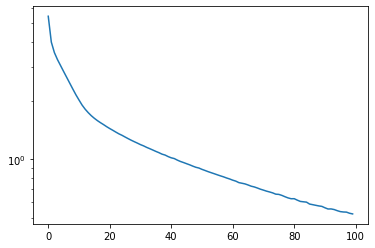

Accuracy by the propagration model is 0.9798


100%|██████████| 100/100 [00:00<00:00, 222.11it/s]


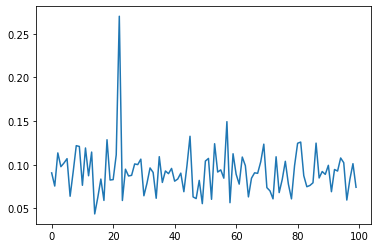

Task 0, Accuracy: 0.9801


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


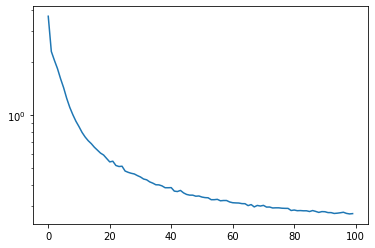

Accuracy by the propagration model is 0.9685


100%|██████████| 100/100 [00:00<00:00, 112.01it/s]


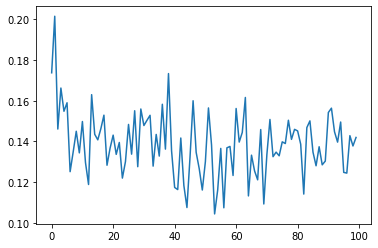

Task 1, Accuracy: 0.9695


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


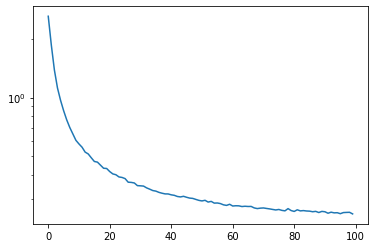

Accuracy by the propagration model is 0.9619


100%|██████████| 100/100 [00:01<00:00, 73.61it/s]


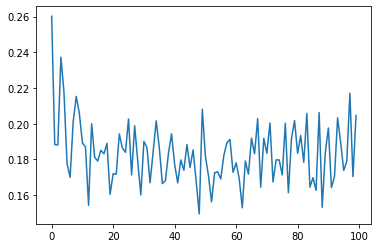

Task 2, Accuracy: 0.9662


100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


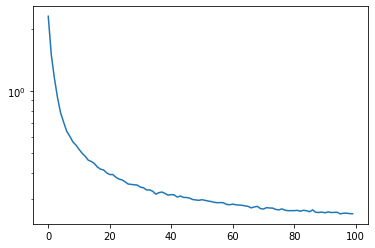

Accuracy by the propagration model is 0.9551


100%|██████████| 100/100 [00:01<00:00, 55.35it/s]


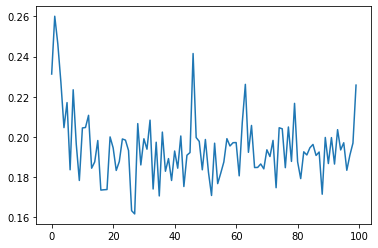

Task 3, Accuracy: 0.9608


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


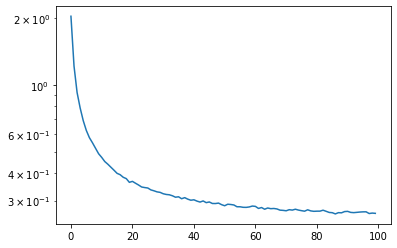

Accuracy by the propagration model is 0.9506


100%|██████████| 100/100 [00:02<00:00, 44.96it/s]


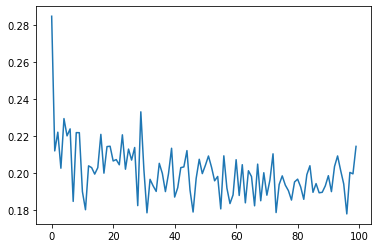

Task 4, Accuracy: 0.9572


100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


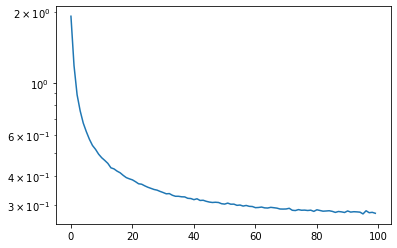

Accuracy by the propagration model is 0.9382


100%|██████████| 100/100 [00:02<00:00, 43.44it/s]


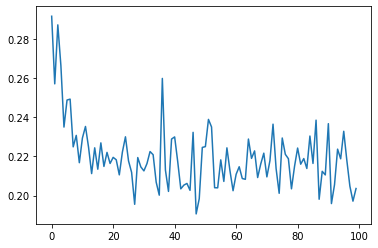

Task 5, Accuracy: 0.9519


100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


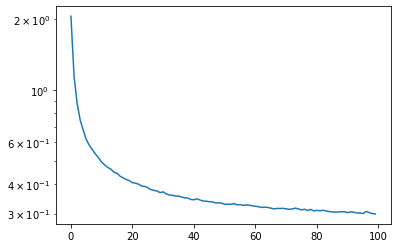

Accuracy by the propagration model is 0.9093


100%|██████████| 100/100 [00:02<00:00, 36.29it/s]


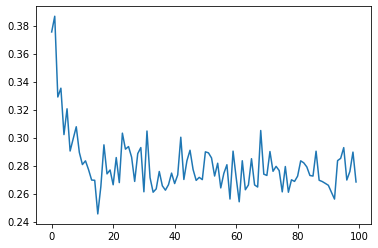

Task 6, Accuracy: 0.9390


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


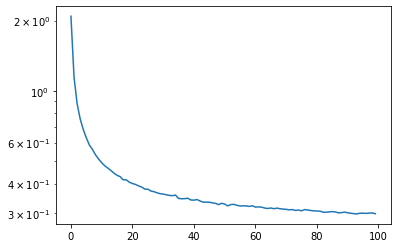

Accuracy by the propagration model is 0.8878


100%|██████████| 100/100 [00:03<00:00, 31.05it/s]


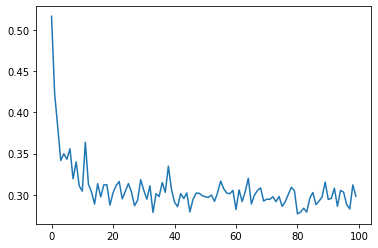

Task 7, Accuracy: 0.9306


100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


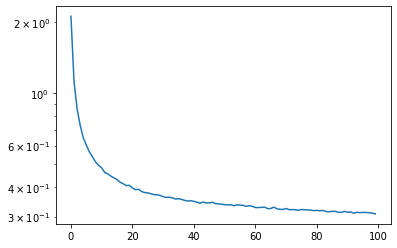

Accuracy by the propagration model is 0.8883


100%|██████████| 100/100 [00:03<00:00, 26.65it/s]


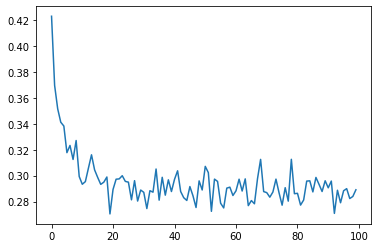

Task 8, Accuracy: 0.9251


100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


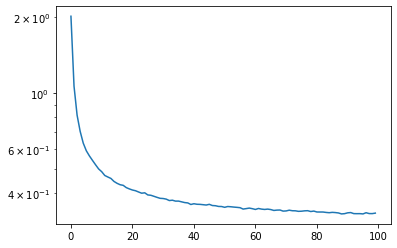

Accuracy by the propagration model is 0.8557


100%|██████████| 100/100 [00:04<00:00, 23.50it/s]


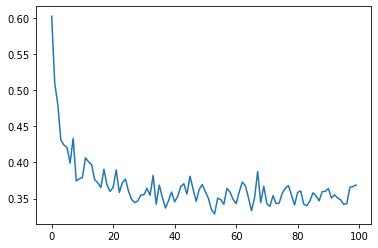

Task 9, Accuracy: 0.9117


In [11]:
for task in range(10):
    train_x, train_y, test_x, test_y = get_pMNIST(task, device)
    Test_x.append(test_x)
    Test_y.append(test_y)
    
    # define current model
    current_model = VCL_permute_MNIST(previous_model=previous_model, first_model=True if task==0 else False).to(device)
    current_opt = torch.optim.Adam(current_model.parameters(), lr=0.001)

    # get coreset
    if random_coreset:
        coreset_idx = np.random.choice(train_x.shape[0], coreset_size, False)
    else:
        coreset_idx = np.array(KCenter(coreset_size).fit_tranform(train_x.cpu().detach().numpy())[-1]) 
    train_idx = np.delete(np.arange(train_x.shape[0]), coreset_idx)
    new_coreset_x = train_x[coreset_idx]
    new_coreset_y = train_y[coreset_idx]
    train_x = train_x[train_idx]
    train_y = train_y[train_idx]

    if coreset_x == None:
        coreset_x = new_coreset_x
        coreset_y = new_coreset_y
    else:
        coreset_x = torch.cat([new_coreset_x, coreset_x])
        coreset_y = torch.cat([new_coreset_y, coreset_y])
        # "For all the algorithms with coresets, we choose 200 examples from each task to include into the coresets"

    ELBO = []
    for epoch in tqdm(range(100)):
        ELBO_batch = []
        for batch in range(int(np.ceil(train_x.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            
            current_opt.zero_grad()
            elbo = current_model.calculate_ELBO(x=train_x[batch_idx0: batch_idx1], 
                                                y=train_y[batch_idx0: batch_idx1], 
                                                n_particles=1,
                                                dataset_size=train_x.shape[0])
            elbo.backward()
            nn.utils.clip_grad_value_(current_model.parameters(), 5)
            current_opt.step()
            ELBO_batch.append(elbo.item())
        ELBO.append(np.mean(ELBO_batch))
    plt.plot(ELBO)
    plt.yscale("log")
    plt.show()

    test_x_tensor = torch.cat(Test_x)
    test_y_tensor = torch.cat(Test_y)
    pred_y = []
    with torch.no_grad():
        for batch in range(int(np.ceil(test_x_tensor.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            pred_logit_samples = nn.Softmax(-1)(torch.stack(current_model.predict(test_x_tensor[batch_idx0: batch_idx1], 100), 0)).mean(0)
            pred_y.append(pred_logit_samples.argmax(-1))
        pred_y = torch.cat(pred_y)
        acc = (pred_y == test_y_tensor).cpu().numpy().mean()
    print("Accuracy by the propagration model is %.4f"%acc)
        
    # calculate prediction model
    pred_model = VCL_permute_MNIST(previous_model=current_model).to(device)
    pred_opt = torch.optim.Adam(pred_model.parameters(), lr=0.001)

    ELBO = []
    for epoch in tqdm(range(100)):
        ELBO_batch = []
        for batch in range(int(np.ceil(coreset_x.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            pred_opt.zero_grad()
            elbo = pred_model.calculate_ELBO(x=coreset_x[batch_idx0: batch_idx1], 
                                             y=coreset_y[batch_idx0: batch_idx1], 
                                             n_particles=1,
                                             dataset_size=coreset_x.shape[0])
            elbo.backward()
            nn.utils.clip_grad_value_(pred_model.parameters(), 5)
            pred_opt.step()
            ELBO_batch.append(elbo.item())
        ELBO.append(np.mean(ELBO_batch))
    plt.plot(ELBO)
    plt.show()
            
    test_x_tensor = torch.cat(Test_x)
    test_y_tensor = torch.cat(Test_y)
    pred_y = []
    with torch.no_grad():
        for batch in range(int(np.ceil(test_x_tensor.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            pred_logit_samples = nn.Softmax(-1)(torch.stack(pred_model.predict(test_x_tensor[batch_idx0: batch_idx1], 100), 0)).mean(0)
            pred_y.append(pred_logit_samples.argmax(-1))
        pred_y = torch.cat(pred_y)
        acc = (pred_y == test_y_tensor).cpu().numpy().mean()
    Accuracies.append(acc)
    print("Task {:d}, Accuracy: {:.4f}".format(task, acc))
    previous_model = current_model

In [12]:
print(Accuracies)

[0.9801, 0.96945, 0.9662, 0.96085, 0.95718, 0.95195, 0.9389714285714286, 0.93065, 0.9251444444444444, 0.91175]


Text(0, 0.5, 'Accuracy')

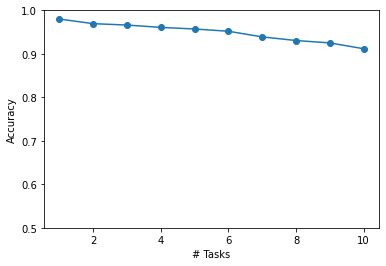

In [13]:
plt.plot(np.arange(1, 11), Accuracies)
plt.scatter(np.arange(1, 11), Accuracies)
plt.ylim(0.5, 1)
plt.xlabel("# Tasks")
plt.ylabel("Accuracy")